## Download the data:
- High resolution fields for validation
- Low resolution upsampled fields as an input of the neural network
- The High resolution land mask
- The weights of the NN

In [1]:
import os

flag_file = 'first_run_flag.txt' ## Flag to know if the files are downloaded or not, in order to use "run all cells"

if not os.path.exists(flag_file):
    !mc alias set publics3 $S3_ENDPOINT "" ""
    !mc cp --recursive s3/oidc-antoinebernigaud/SRDA/data .
    with open(flag_file, 'w') as f:
        f.write('Commands executed.')

else:
    print('Commands have already been executed.')

Commands have already been executed.


## Install necessary dependancies, import the necessary modules and define plot functions

In [2]:
!pip install -q NetCDF4
!pip install -q matplotlib

In [14]:
from data_generator3V2 import Data_generator, generate_dates, convert_date_format, \
                            load_standardization_data
from models.attention_res_net3V2 import Att_Res_UNet
import tensorflow as tf
import re
import numpy as np
import numpy.ma as ma
import abfile
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm

%matplotlib inline
%load_ext autoreload

def plot_fld(vname, fld, max_abs_val=None, min_abs_val=None, log=False):
    f, ax1 = plt.subplots(1, 1, figsize=(11, 11))

    # Auto-scale limits if not provided
    if max_abs_val is None and min_abs_val is None:
        if log:
            # log scale requires positive values
            min_abs_val = np.nanmin(fld[fld > 0])
            max_abs_val = np.nanmax(fld)
        else:
            max_abs_val = np.nanmax(fld)
            min_abs_val = np.nanmin(fld)

    if log:
        P = ax1.pcolormesh(fld, cmap='viridis', norm=LogNorm(vmin=min_abs_val, vmax=max_abs_val))
    else:
        P = ax1.pcolormesh(fld, cmap='seismic', vmin=min_abs_val, vmax=max_abs_val)

    plt.colorbar(P, ax=ax1)
    ax1.set_title(vname)
    plt.tight_layout()

def plot_flds(vnames, flds, max_abs_val=None, min_abs_val=None, log=False):
    num_images = len(flds)
    f, axes = plt.subplots(1, num_images, figsize=(14*num_images, 14))

    if not isinstance(axes, np.ndarray):
        axes = [axes]  # Ensure list for consistency

    # Auto-scale limits if not provided
    if max_abs_val is None and min_abs_val is None:
        if log:
            min_abs_val = min(np.nanmin(fld[fld > 0]) for fld in flds)
            max_abs_val = max(np.nanmax(fld) for fld in flds)
        else:
            max_abs_val = max(np.nanmax(fld) for fld in flds)
            min_abs_val = min(np.nanmin(fld) for fld in flds)

    for ax, fld, vname in zip(axes, flds, vnames):
        if log:
            P = ax.pcolormesh(fld, cmap='viridis', norm=LogNorm(vmin=min_abs_val, vmax=max_abs_val))
        else:
            P = ax.pcolormesh(fld, cmap='seismic', vmin=min_abs_val, vmax=max_abs_val)

        f.colorbar(P, ax=ax)
        ax.set_title(vname)

    plt.tight_layout()

cmap = plt.colormaps["bwr"]
cmap.set_bad('gray')
def plot_res(vname,fld,max_abs_val = None) :
    """
    Plot residual data with a red/white/blue centered at 0 color colorbar.

    Args:
        vname (str): The name of the variable being plotted.
        fld (numpy.ndarray): The field data to be plotted.
        max_abs_val (float, optional): The maximum absolute value for color scale.
            If None, maximum absolute value in `fld` is used. Defaults to None.
    Returns:
        None
    """
    f, (ax1) = plt.subplots(1, 1, figsize=(10, 8))
    if max_abs_val is None:
        max_abs_val = np.max(np.abs(fld))
    P = ax1.pcolormesh(fld, cmap=cmap, vmin=-max_abs_val, vmax=max_abs_val) ; plt.colorbar(P,ax=ax1); ax1.set_title(vname);

def plot_res_side(vnames, fields, max_abs_val=None):
    num_fields = len(vnames)
    if max_abs_val is None:
        max_abs_val = max(np.max(np.abs(fld)) for fld in fields)

    fig, axes = plt.subplots(1, num_fields, figsize=(7*num_fields, 7))  # Adjust figure size based on the number of fields

    cmap = plt.get_cmap("bwr").copy()
    cmap.set_bad('gray')

    for i in range(num_fields):
        P = axes[i].pcolormesh(fields[i], cmap=cmap, vmin=-max_abs_val, vmax=max_abs_val)
        plt.colorbar(P, ax=axes[i])
        axes[i].set_title(vnames[i])

    plt.tight_layout()  # Adjust subplot parameters to give specified padding
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define the dates to perform the super resolution and define the path to access the data

In [4]:
# Minimum and maximum date to perform the super-resolution
date_min_test = '2018_003'
date_max_test = '2018_003'

days_range = 7 # number of days between two predictions
dates_test = generate_dates(date_min_test, date_max_test, days_range)
print('date list of testing days:')
print(dates_test)
print(f'number of testing days: {len(dates_test)}')

# Define the path for the data
paths = {}
root_data_dir = 'data'
# Path to the low resolution upsampled data and residuals data
paths["data_HR"] = os.path.join(root_data_dir,"HR")
paths["data_LR_upsampled"] = os.path.join(root_data_dir,"LR_upsampled")
# Path to the standardization files containing the mean / variance of the field
# for normalization
paths["standard"] = root_data_dir
paths["forcings"] = root_data_dir
file_standardization_res = os.path.join(paths["data_HR"],"standard_residuals.h5")
file_standardization_LR_upsampled = os.path.join(paths["data_LR_upsampled"],"standard_LR_upsampled.h5")

# Path for the model weights
paths["model_weights"] = 'weights/'

date list of testing days:
['2018_003']
number of testing days: 1


## Define the Predictors and the parameters for the test

In [5]:
## Choose the variable to super resolve

# the predictors must have the name "fieldname-layer-layernumber"
# variables available: temp, saln, u, v, dp, ECO_flac, ECO_diac, ECO_cclc
# layers : from 1 to 50

variable = 'ECO_flac'
layer = 1

def generate_layer_names(var: str, layer: int):
    if not isinstance(var, str) or not isinstance(layer, int):
        raise ValueError("Invalid input types. Expected (str, int).")
    
    if layer < 1 or layer > 50:
        raise ValueError("Layer must be between 1 and 50.")

    start = max(1, layer - 1)
    end = min(51, layer + 2)

    result = [f"{var}-layer-{i}" for i in range(start, end)]
    
    if var == "dp":
        result = [f"dp-layer-{i}" for i in range(1 if layer == 1 else start + 1, 51 if layer == 50 else end - 1)] + \
                 [f"temp-layer-{i}" for i in range(1 if layer == 1 else start + 1, 51 if layer == 50 else end - 1)] + \
                 [f"saln-layer-{i}" for i in range(1 if layer == 1 else start + 1, 51 if layer == 50 else end - 1)]
    if var == "u":
        result = [f"u-layer-{i}" for i in range(start, end)] + \
                 [f"v-layer-{i}" for i in range(start, end)]
    if var == "v":
        result = [f"v-layer-{i}" for i in range(start, end)] + \
                 [f"u-layer-{i}" for i in range(start, end)] 
    return result

list_predictors = generate_layer_names(variable,layer) + ["tp5_mask"]
list_targets = [f"{variable}-layer-{layer}"]
checkpoint_file_name = f"Checkpoints_3V201_{variable}_Pred-{layer}_Target-{layer}.h5"
print('list predictors : ', list_predictors)
print('list targets : ', list_targets)


def generate_checkpoint_filename(variable: str, layer: int):
    if layer < 1 or layer > 50:
        raise ValueError("Layer must be between 1 and 50.")
    if variable == 'dp' and layer < 10:
        raise ValueError("The layer depth in hycom is fixed for the first 10 layers -> no super-resolution needed.")

    if variable == 'dp':
        layer_str = "_".join(map(str, range(layer, layer + 1)))
    else:
        start = max(1, layer - 1)
        end = min(50, layer + 1)
        layer_str = "_".join(map(str, range(start, end + 1)))
        
    return f"Checkpoints_3V201_{variable}_Pred-{layer_str}_Target-{layer}.h5"


file_model_weights = os.path.join(paths["model_weights"],generate_checkpoint_filename(variable, layer))
print('file_model_weights : ', file_model_weights)
basename_weights = os.path.basename(file_model_weights)

# Download the weight and move it in the right dir
!mc cp s3/oidc-antoinebernigaud/SRDA/weights/{basename_weights} .
!mv {basename_weights} weights/

list predictors :  ['ECO_flac-layer-1', 'ECO_flac-layer-2', 'tp5_mask']
list targets :  ['ECO_flac-layer-1']
file_model_weights :  weights/Checkpoints_3V201_ECO_flac_Pred-1_2_Target-1.h5
...arget-1.h5: 13.09 MiB / 13.09 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 128.90 MiB/s 0s

In [6]:
# Load standardization files
dummy_standard_file = os.path.join("data", "LR_upsampled", "standard_LR_upsampled.h5")
standard_LR_upsampled = load_standardization_data(dummy_standard_file)
standard_HR = load_standardization_data(dummy_standard_file)
standard_forcings = load_standardization_data(dummy_standard_file)
standard_bathy = load_standardization_data(dummy_standard_file)

# Model Parameters
model_params = {"list_predictors": list_predictors,
                "list_targets": list_targets,
                "dim": (760, 800), # (jdm,idm) dimension of the fields
                "cropped_dim": (768, 800), # dimension of the fields with padding for the Unet
                "batch_size": 1,
                "n_filters": [32*(i+1) for i in range(6)],
                "activation": "relu",
                "kernel_initializer": "he_normal",
                "batch_norm": True,
                "pooling_type": "Average",
                "dropout": 0,
               }

# Testing Parameters
params_test = {"list_predictors": model_params["list_predictors"],
                "list_labels": model_params["list_targets"],
                "list_dates": dates_test,
                "standard_forcings": standard_forcings,
                "standard_res": standard_LR_upsampled,
                "standard_LR_upsampled": standard_LR_upsampled,
                "standard_bathy": standard_bathy,
                "batch_size": model_params["batch_size"],
                "path_data_res": paths["data_HR"],
                "path_forcings": paths["forcings"],
                "path_data_LR_upsampled": paths["data_LR_upsampled"],
                "dim": model_params["dim"],
                "cropped_dim": model_params["cropped_dim"],
                "shuffle": False,
                "res_normalization":0,
                "dtime": 1,
                "mem": None # if the file is an EnKF member: None or "_mem003" for instance
                }
#
model_and_compile_params = {**model_params, **params_test}

## Initialize the Neural Network

In [7]:
# Initialization of the data generator (used to load the data dynamically into the memory)
# and of the Neural network
test_generator = Data_generator(**params_test)
unet_model = Att_Res_UNet(**model_params).make_unet_model()
unet_model.load_weights(file_model_weights)

I0000 00:00:1764774142.211681    1754 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1764774142.240835    1754 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1764774142.241094    1754 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1764774142.243374    1754 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## Prediction of the HR field

In [8]:
# Prediction on the first element of the first batch
predict_batch = unet_model.predict(test_generator[0][0]) # prediction on test_generator['batch_number']['predictors']

if layer == 0:
    predictor_no = 0
else:
    predictor_no = 1

# Get the field corresponding to the chosen target in the prediction
predict = predict_batch[0, :, :, 0]
# Crop the prediction to match the dimension of the real field
predict = predict[0:760, :]
# Same thing for the input (X) and the truth (y)
X_batch, y_batch = test_generator[0]
X = X_batch[0, ..., predictor_no]
y = y_batch[0, ..., 0]
X = X[0:760, :]
y = y[0:760, :]

## Apply land mask
tp5mask = np.load(os.path.join('/home/onyxia/work/Super_Resolution_Data_Assimilation/data','tp5mask.npy') )
tp5mask_augmented = np.copy(tp5mask)  # We mask the Golf of Ob for the results as it is not a region of interest
tp5mask_augmented[480:530, 675:800] = 1 
y = np.ma.masked_array(y, tp5mask_augmented)
predict = np.ma.masked_array(predict, tp5mask_augmented)
X = np.ma.masked_array(X, tp5mask_augmented)

I0000 00:00:1764774145.251283    1846 service.cc:146] XLA service 0x7fb10806e3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764774145.251327    1846 service.cc:154]   StreamExecutor device (0): NVIDIA RTXA6000-48Q, Compute Capability 8.6
2025-12-03 15:02:25.326960: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 15:02:25.582902: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8900


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1764774147.616005    1846 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


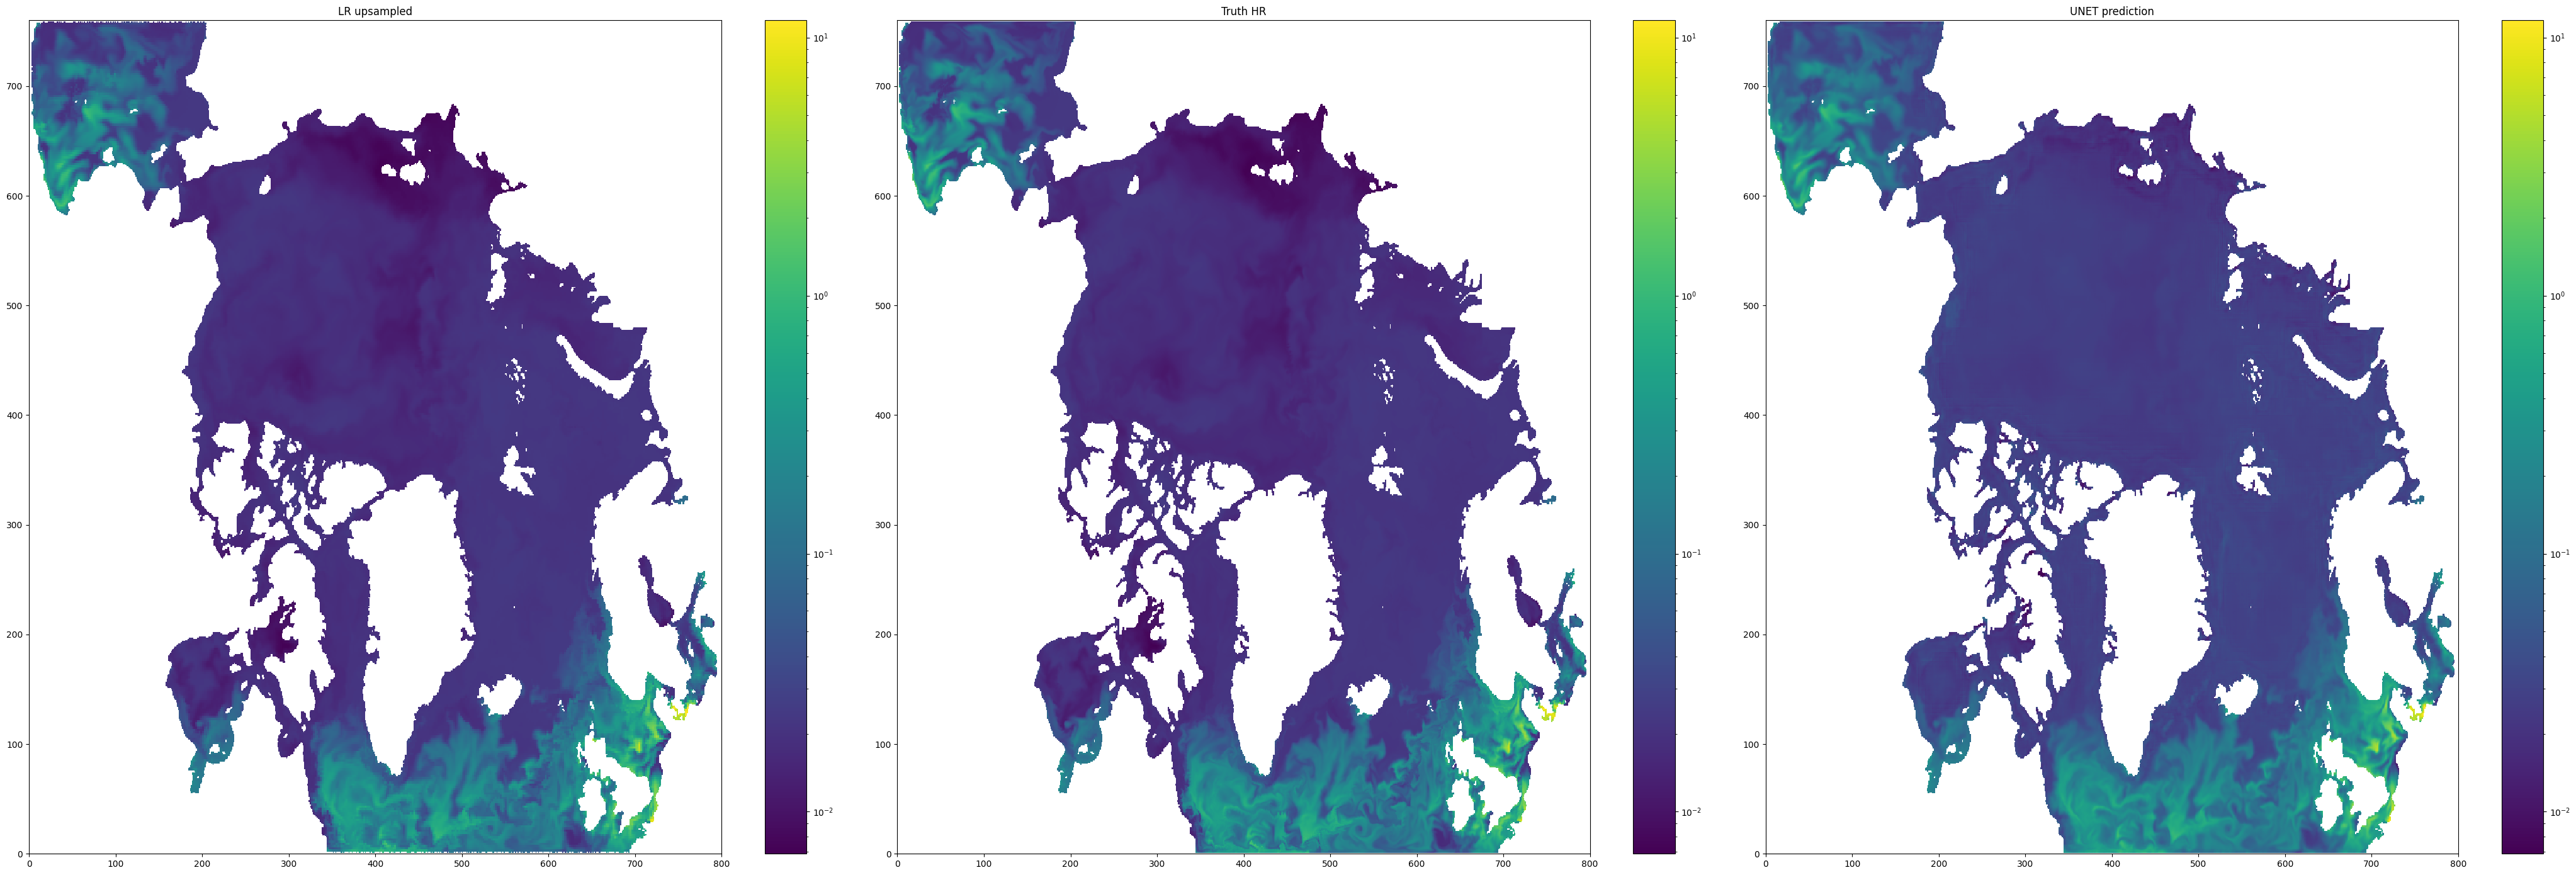

In [11]:
## Plot some fields

vmax = np.max(y)
vmin = np.min(y)

plot_flds(['LR upsampled', 'Truth HR', 'UNET prediction'], [X, y, predict], vmax, vmin, log = 'ECO' in variable)

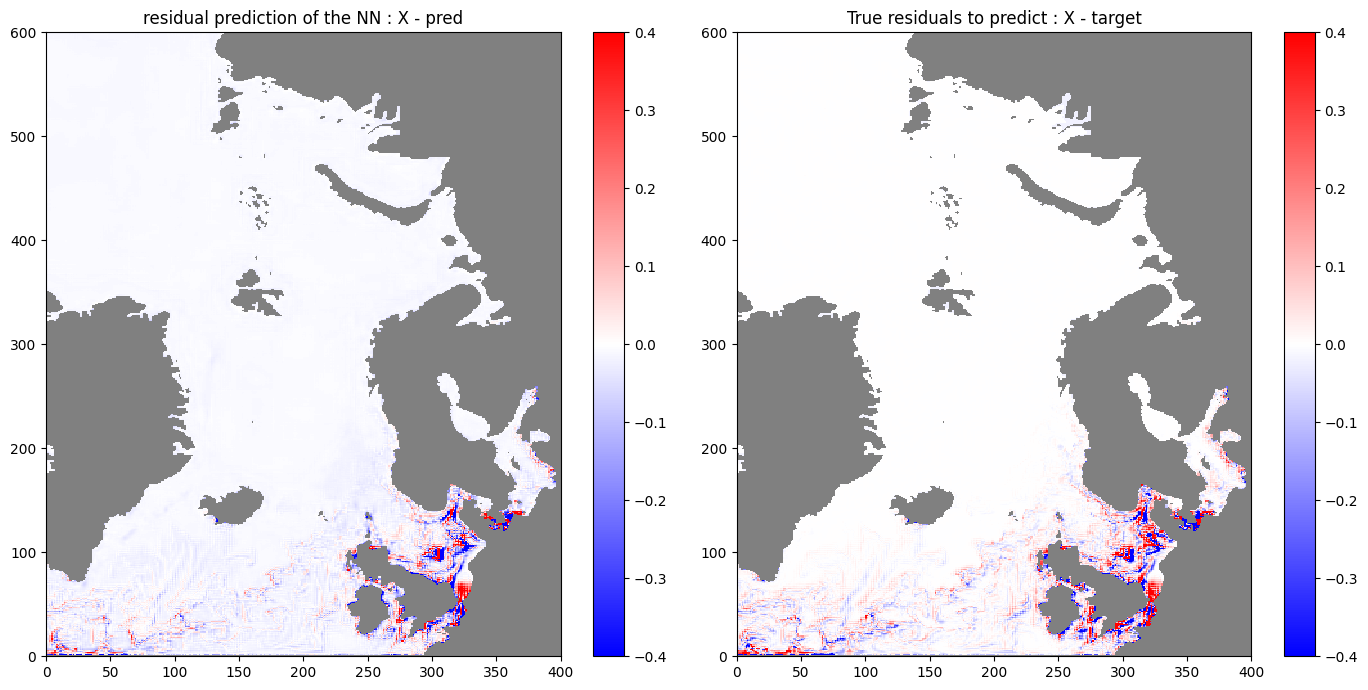

In [15]:
## Plot some difference

true_residuals = X - y
predicted_residuals = X - predict

vmax = np.max(true_residuals)
vmax = 0.4

plot_res_side(['residual prediction of the NN : X - pred', 'True residuals to predict : X - target'], [predicted_residuals[0:600,400:800], true_residuals[0:600,400:800]], vmax)

## Comparison against baseline with different metrics

#### Bias and MSE

Bias between Unet prediction and truth: -1.0787e-02
Bias between Bilinear interpolation and truth: 4.7301e-05
Bias: Bilinear Interpolation has the better result.

MSE between Unet prediction and truth: 5.9693e-03
MSE between Bilinear interpolation and truth 1.1653e-02
MSE: Unet Prediction has the better result.
relative change in the MSE of -48.775 %

PSNR Unet prediction 162.037
PSNR  Bilinear interpolation 155.347
PSNR: Unet Prediction has the better result.



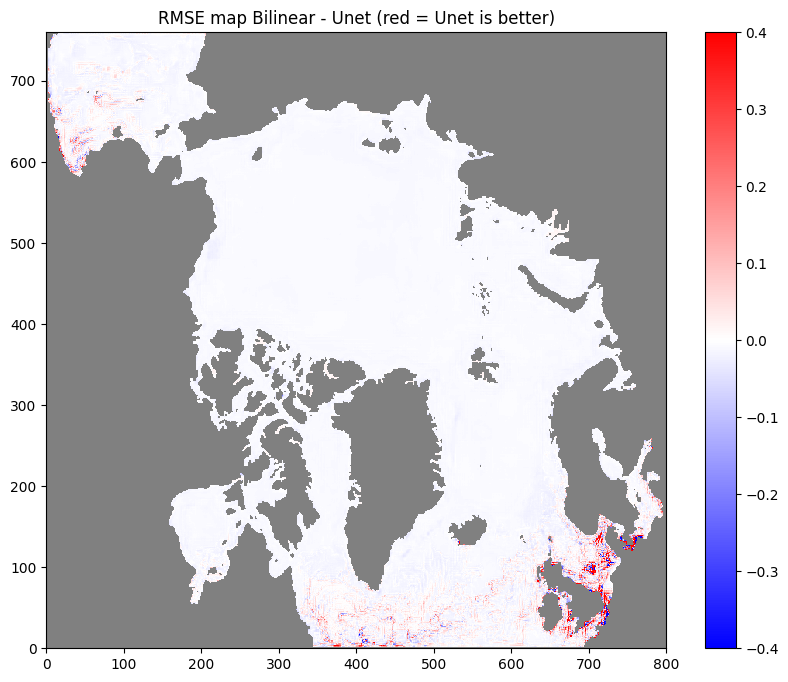

In [16]:
# Compute bias
bias_pred = np.mean(y) - np.mean(predict)
bias_interp = np.mean(y) - np.mean(X)
print('Bias between Unet prediction and truth: {:.4e}'.format(bias_pred))
print('Bias between Bilinear interpolation and truth: {:.4e}'.format(bias_interp))
if abs(bias_pred) < abs(bias_interp):
    bias_result = "Unet Prediction"
else:
    bias_result = "Bilinear Interpolation"
print('Bias:', bias_result, 'has the better result.')
print()

# MSE
mse_upsample = np.mean(np.square(y - X)) # truth - LR_upsampled = truth - X = y
mse_unet = np.mean(np.square(y - predict)) # truth - prediction_reconstructed = y + X - (pred + X) = y - pred
delta_mse = (mse_unet - mse_upsample)/mse_upsample
print('MSE between Unet prediction and truth: {:.4e}'.format(mse_unet))
print('MSE between Bilinear interpolation and truth {:.4e}'.format(mse_upsample))
if mse_upsample > mse_unet:
    mse_result = "Unet Prediction"
else:
    mse_result = "Bilinear Interpolation"
print('MSE:', mse_result, 'has the better result.')
print('relative change in the MSE of {:.3f} %'.format(delta_mse*100) )
print()

# Peak Signal to Noise Ration
psnr_upsample = 10*np.log(255**2/mse_upsample)
psnr_unet = 10*np.log(255**2/mse_unet)
print('PSNR Unet prediction {:.3f}'.format(psnr_unet))
print('PSNR  Bilinear interpolation {:.3f}'.format(psnr_upsample))
if psnr_unet > psnr_upsample:
    psnr_result = "Unet Prediction"
else:
    psnr_result = "Bilinear Interpolation"
print('PSNR:', psnr_result, 'has the better result.')
print()

#RMSE MAP
RMSE_MAP_upsample = np.sqrt(np.square(y - X))
RMSE_MAP_unet = np.sqrt(np.square(y - predict))
RMSE_MAP = RMSE_MAP_upsample - RMSE_MAP_unet # Red means RMSE_MAP_upsample > RMSE_MAP_unet
                                             # meaning better results for the Unet
plot_res('RMSE map Bilinear - Unet (red = Unet is better)', RMSE_MAP, 0.4)

#### Spectral Power

In [ ]:
!pip install scipy

In [ ]:
import scipy.stats as stats

def power_spectrum(xx):
    """
    https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
    """
    
    ny,nx = xx.shape

    npix = min(nx, ny)
    fourier_image = np.fft.fftn(xx)
    fourier_amplitudes = np.abs(fourier_image)**2
    #By default, the wave vectors are given as a fraction of 1, by multiplying with the total number of pixels, we convert them to a pixel frequency.
    kfreqx = np.fft.fftfreq(nx) * nx
    kfreqy = np.fft.fftfreq(ny) * ny
    kfreq2D = np.meshgrid(kfreqy,kfreqx)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm=knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    #fourier_amplitudes=fourier_amplitudes.reshape(n,-1)
    #fourier_amplitudes_mean = np.mean(fourier_amplitudes,axis=0)
    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic ="mean",
                                     bins = kbins)
    #Abins *= 4. * np.pi / 3. * (kbins[1:]**3 - kbins[:-1]**3)
    #Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins

In [ ]:
# We need to select a square region without mask
range_rowsHR = slice(210, 310)
range_colsHR = slice(515, 615)
range_rowsHR = slice(10, 110)
range_colsHR = slice(500, 600)
subregion_len = range_colsHR.stop - range_colsHR.start
vmax_subregion = np.max(y[range_rowsHR,range_colsHR])

plot_flds(['LR', 'HR', 'NN prediction'], [X[range_rowsHR,range_colsHR], y[range_rowsHR,range_colsHR], predict[range_rowsHR,range_colsHR]], vmax_subregion)

In [ ]:
!pip install -q seaborn

In [ ]:
import matplotlib.ticker as ticker
import seaborn as sns

sns.set(style="whitegrid")

klr, Alr = power_spectrum(X[range_rowsHR, range_colsHR])
knn, Ann = power_spectrum(predict[range_rowsHR, range_colsHR])
khr, Ahr = power_spectrum(y[range_rowsHR, range_colsHR])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set both axes to be in log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Set the labels and title
ax.set_xlabel('Resolution (km)', fontsize=14)
ax.set_ylabel('Power Spectrum', fontsize=14)
ax.set_title('Power Spectrum on the above fields', fontsize=16)

# Calculate kpredic_km (assuming it makes sense to do this calculation)
kpredic_km = 6 * subregion_len / khr

# Number of ticks to display
num_labels = 10
step = len(kpredic_km) // num_labels
reduced_ticks_predict = knn[::step]
reduced_ticks_km = kpredic_km[::step]

# Set the ticks and labels
ax.set_xticks(reduced_ticks_predict)
ax.set_xticklabels([f'{int(x_km)}' for x_km in reduced_ticks_km])
y_ticks = [10**i for i in range(int(np.log10(min(Ann))), int(np.log10(max(Ann))) + 1)]
ax.set_yticks(y_ticks)

# Plotting
ax.plot(knn[:-1], Ann[:-1], label="Predicted", color='blue', linewidth=1)
ax.plot(klr[:-1], Alr[:-1], label="KL", color='green', linewidth=1)
ax.plot(khr[:-1], Ahr[:-1], label="Khr", color='red', linewidth=1)

for tick in reduced_ticks_predict:
    ax.axvline(x=tick, color='grey', linestyle='--', linewidth=0.5)

ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#### Vorticity

In [ ]:
def compute_vorticity(u, v):
    zeta = (np.roll(v, -1, axis=1) - np.roll(v, 1, axis=1) - np.roll(u, -1, axis=0) + np.roll(u, 1, axis=0)) / 2.0
    return zeta

In [ ]:
## Choose the variable to super resolve

# the predictors must have the name "fieldname-layer-layernumber"
# variables available: temp, saln, u, v, dp
# layers : from 1 to 50

variable1 = 'u'
layer1 = 1

list_predictors1 = generate_layer_names(variable1,layer1) + ["tp5_mask"]
list_targets1 = [f"{variable1}-layer-{layer1}"]
checkpoint_file_name1 = f"Checkpoints_3V201_{variable1}_Pred-{layer1}_Target-{layer1}.h5"
print('list predictors : ', list_predictors1)
print('list targets : ', list_targets1)
file_model_weights1 = os.path.join(paths["model_weights"],generate_checkpoint_filename(variable1, layer1))
print('file_model_weights : ', file_model_weights1)
basename_weights1 = os.path.basename(file_model_weights1)
!mc cp s3/oidc-antoinebernigaud/SRDA/weights/{basename_weights1} .
!mv {basename_weights1} weights/

variable2 = 'v'
layer2 = 1
list_predictors2 = generate_layer_names(variable2,layer2) + ["tp5_mask"]
list_targets2 = [f"{variable2}-layer-{layer2}"]
checkpoint_file_name2 = f"Checkpoints_3V201_{variable2}_Pred-{layer2}_Target-{layer2}.h5"
print('list predictors : ', list_predictors2)
print('list targets : ', list_targets2)
file_model_weights2 = os.path.join(paths["model_weights"],generate_checkpoint_filename(variable2, layer2))
print('file_model_weights : ', file_model_weights2)
basename_weights2 = os.path.basename(file_model_weights2)
!mc cp s3/oidc-antoinebernigaud/SRDA/weights/{basename_weights2} .
!mv {basename_weights2} weights/

# Model Parameters
model_params1 = {"list_predictors": list_predictors1,
                "list_targets": list_targets1,
                "dim": (760, 800), # (jdm,idm) dimension of the fields
                "cropped_dim": (768, 800), # dimension of the fields with padding for the Unet
                "batch_size": 1,
                "n_filters": [32*(i+1) for i in range(6)],
                "activation": "relu",
                "kernel_initializer": "he_normal",
                "batch_norm": True,
                "pooling_type": "Average",
                "dropout": 0,
               }

# Testing Parameters
params_test1 = {"list_predictors": model_params1["list_predictors"],
                "list_labels": model_params1["list_targets"],
                "list_dates": dates_test,
                "standard_forcings": standard_forcings,
                "standard_res": standard_HR,
                "standard_LR_upsampled": standard_LR_upsampled,
                "standard_bathy": standard_bathy,
                "batch_size": model_params["batch_size"],
                "path_data_res": paths["data_HR"],
                "path_forcings": paths["forcings"],
                "path_data_LR_upsampled": paths["data_LR_upsampled"],
                "dim": model_params["dim"],
                "cropped_dim": model_params["cropped_dim"],
                "shuffle": False,
                "res_normalization":0,
                "dtime": 1,
                "mem": None # if the file is an EnKF member: None or "_mem003" for instance
                }
#
model_params2 = {"list_predictors": list_predictors2,
                "list_targets": list_targets2,
                "dim": (760, 800), # (jdm,idm) dimension of the fields
                "cropped_dim": (768, 800), # dimension of the fields with padding for the Unet
                "batch_size": 1,
                "n_filters": [32*(i+1) for i in range(6)],
                "activation": "relu",
                "kernel_initializer": "he_normal",
                "batch_norm": True,
                "pooling_type": "Average",
                "dropout": 0,
               }

# Testing Parameters
params_test2 = {"list_predictors": model_params2["list_predictors"],
                "list_labels": model_params2["list_targets"],
                "list_dates": dates_test,
                "standard_forcings": standard_forcings,
                "standard_res": standard_HR,
                "standard_LR_upsampled": standard_LR_upsampled,
                "standard_bathy": standard_bathy,
                "batch_size": model_params["batch_size"],
                "path_data_res": paths["data_HR"],
                "path_forcings": paths["forcings"],
                "path_data_LR_upsampled": paths["data_LR_upsampled"],
                "dim": model_params["dim"],
                "cropped_dim": model_params["cropped_dim"],
                "shuffle": False,
                "res_normalization":0,
                "dtime": 1,
                "mem": None # if the file is an EnKF member: None or "_mem003" for instance
                }
#
# Initialization of the data generator (used to load the data dynamically into the memory)
# and of the Neural network
test_generator1 = Data_generator(**params_test1)
test_generator2 = Data_generator(**params_test2)

unet_model1 = Att_Res_UNet(**model_params1).make_unet_model()
unet_model1.load_weights(file_model_weights1)
unet_model2 = Att_Res_UNet(**model_params2).make_unet_model()
unet_model2.load_weights(file_model_weights2)

In [ ]:
# Prediction on the first element of the first batch
predict_batch1 = unet_model1.predict(test_generator1[0][0]) # prediction on test_generator['batch_number']['predictors']

if layer1 == 1:
    predictor_no1 = 0
else:
    predictor_no1 = 1
    
# Get the field corresponding to the chosen target in the prediction
predict1 = predict_batch1[0,:,:,0]
# Crop the prediction to match the dimension of the real field
predict1 = predict1[0:760,:]
# Same thing for the input (X) and the truth (y)
X_batch1, y_batch1 = test_generator1[0]
X1 = X_batch1[0,...,predictor_no1]
y1 = y_batch1[0,...,0]
X1 = X1[0:760,:]
y1 = y1[0:760,:]

y1 = np.ma.masked_array(y1, tp5mask_augmented)
predict1 = np.ma.masked_array(predict1, tp5mask_augmented)
X1 = np.ma.masked_array(X1, tp5mask_augmented)

# Prediction on the first element of the first batch
predict_batch2 = unet_model2.predict(test_generator2[0][0]) # prediction on test_generator['batch_number']['LR field upsampled']

if layer2 == 1:
    predictor_no2 = 0
else:
    predictor_no2 = 1
    
# Get the field corresponding to the chosen target in the prediction
predict2 = predict_batch2[0,:,:,0]
# Crop the prediction to match the dimension of the real field
predict2 = predict2[0:760,:]
# Same thing for the input (X) and the truth (y)
X_batch2, y_batch2 = test_generator2[0]
X2 = X_batch2[0,...,predictor_no2]
y2 = y_batch2[0,...,0]
X2 = X2[0:760,:]
y2 = y2[0:760,:]

y2 = np.ma.masked_array(y2, tp5mask_augmented)
predict2 = np.ma.masked_array(predict2, tp5mask_augmented)
X2 = np.ma.masked_array(X2, tp5mask_augmented)

In [ ]:
vorticity_bilinear = compute_vorticity(X1, X2)
vorticity_prediction = compute_vorticity(predict1, predict2)
vorticity_truth = compute_vorticity(y1, y2)

rmse_bilinear = np.sqrt(np.mean(np.square(vorticity_bilinear - vorticity_truth)))
rmse_prediction = np.sqrt(np.mean(np.square(vorticity_prediction - vorticity_truth)))
print(f'rmse_bilinear total: {rmse_bilinear:.4f}')
print(f'rmse_prediction total: {rmse_prediction:.4f}')
delta_mse = (rmse_prediction - rmse_bilinear)/rmse_bilinear
print('relative change in the MSE over the whole map of {:.3f} %'.format(delta_mse*100) )
print()

rmse_bilinear_sub = np.sqrt(np.mean(np.square(vorticity_bilinear[10:110,500:600] - vorticity_truth[10:110,500:600])))
rmse_prediction_sub = np.sqrt(np.mean(np.square(vorticity_prediction[10:110,500:600] - vorticity_truth[10:110,500:600])))
print(f'rmse_bilinear on subfield: {rmse_bilinear_sub:.4f}')
print(f'rmse_prediction on subfield: {rmse_prediction_sub:.4f}')
delta_mse = (rmse_prediction_sub - rmse_bilinear_sub)/rmse_bilinear_sub
print('relative change in the MSE on the subdomain of {:.3f} %'.format(delta_mse*100) )
print()

plot_res_side(['vorticity_bilinear','vorticity_prediction','vorticity_truth'],[vorticity_bilinear[10:110,500:600],vorticity_prediction[10:110,500:600],vorticity_truth[10:110,500:600]],0.3)

In [ ]:
sns.set(style="whitegrid")

range_rowsHR = slice(10, 110)
range_colsHR = slice(500, 600)
subregion_len = range_colsHR.stop - range_colsHR.start

klr, Alr = power_spectrum(X[range_rowsHR,range_colsHR])
knn, Ann = power_spectrum(predict[range_rowsHR,range_colsHR])
khr, Ahr = power_spectrum(y[range_rowsHR,range_colsHR])

klr, Alr = power_spectrum(vorticity_bilinear[range_rowsHR,range_colsHR])
knn, Ann = power_spectrum(vorticity_prediction[range_rowsHR,range_colsHR])
khr, Ahr = power_spectrum(vorticity_truth[range_rowsHR,range_colsHR])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set both axes to be in log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Set the labels and title
ax.set_xlabel('Resolution (km)', fontsize=14)
ax.set_ylabel('Power Spectrum', fontsize=14)
ax.set_title('Power Spectrum for the vorticity', fontsize=16)

# Calculate kpredic_km (assuming it makes sense to do this calculation)
kpredic_km = 6 * subregion_len / khr

# Number of ticks to display
num_labels = 10
step = len(kpredic_km) // num_labels
reduced_ticks_predict = knn[::step]
reduced_ticks_km = kpredic_km[::step]

# Set the ticks and labels
ax.set_xticks(reduced_ticks_predict)
ax.set_xticklabels([f'{int(x_km)}' for x_km in reduced_ticks_km])
y_ticks = [10**i for i in range(int(np.log10(min(Ann))), int(np.log10(max(Ann))) + 1)]
ax.set_yticks(y_ticks)

# Plotting
ax.plot(knn[:-1], Ann[:-1], label="Predicted", color='blue', linewidth=1)
ax.plot(klr[:-1], Alr[:-1], label="KL", color='green', linewidth=1)
ax.plot(khr[:-1], Ahr[:-1], label="Khr", color='red', linewidth=1)

# Add vertical lines at x-tick positions
for tick in reduced_ticks_predict:
    ax.axvline(x=tick, color='grey', linestyle='--', linewidth=0.5)

ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()